In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, GRU

# Load data
df = pd.read_csv(r'C:\Users\dinhn\Downloads\BNB Historical Data.csv', on_bad_lines='skip', low_memory=False)
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
# Select the Close column as the dependent variable
df_Price = df[['Price']]
df_Price = df_Price.reset_index(drop=True)

# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Price))

# Function to create dataset for time series
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Set time step
time_step = 10

# Split data into train and test sets
train_size = int(0.7 * len(data_scaled))
test_size = len(data_scaled) - train_size
train_data, test_data = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:1]

# Create dataset for training and testing
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1)

# Predict the closing prices for the test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

# Evaluate the accuracy of the test data
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSE on Test dataset: {test_mse}")

Epoch 1/100
42/42 [==============================] - 5s 9ms/step - loss: 0.0240
Epoch 2/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 3/100
42/42 [==============================] - 0s 10ms/step - loss: 0.0010
Epoch 4/100
42/42 [==============================] - 0s 11ms/step - loss: 9.2815e-04
Epoch 5/100
42/42 [==============================] - 1s 13ms/step - loss: 9.0645e-04
Epoch 6/100
42/42 [==============================] - 0s 9ms/step - loss: 8.1990e-04
Epoch 7/100
42/42 [==============================] - 0s 10ms/step - loss: 8.1801e-04
Epoch 8/100
42/42 [==============================] - 1s 14ms/step - loss: 7.4973e-04
Epoch 9/100
42/42 [==============================] - 0s 12ms/step - loss: 7.2470e-04
Epoch 10/100
42/42 [==============================] - 0s 11ms/step - loss: 6.7196e-04
Epoch 11/100
42/42 [==============================] - 1s 12ms/step - loss: 6.4498e-04
Epoch 12/100
42/42 [==============================] - 0s 10ms/step - loss: 6.

42/42 [==============================] - 1s 13ms/step - loss: 5.5564e-04
Epoch 97/100
42/42 [==============================] - 1s 13ms/step - loss: 5.0265e-04
Epoch 98/100
42/42 [==============================] - 1s 13ms/step - loss: 5.2151e-04
Epoch 99/100
42/42 [==============================] - 1s 12ms/step - loss: 5.0975e-04
Epoch 100/100
18/18 [==============================] - 1s 4ms/step
MAPE on Test dataset: 0.018431027971848778
RMSE on Test dataset: 10.989760361556984
MSE on Test dataset: 120.7748328044491


<h2> Predict Price for next 30 days </h2>

Predicted XRP prices for the next 30 days:
[591.60529565 583.62973721 574.24507781 564.90210236 555.99239355
 547.5633629  539.58963411 532.02948343 524.84361339 517.99833475
 511.46652111 505.22422807 499.25085229 493.52801781 488.03886014
 482.76798644 477.70179374 472.82747455 468.13341464 463.60903393
 459.24450804 455.03096719 450.95997915 447.02402646 443.21579058
 439.52882799 435.95701338 432.49461917 429.13635532 425.87732954]


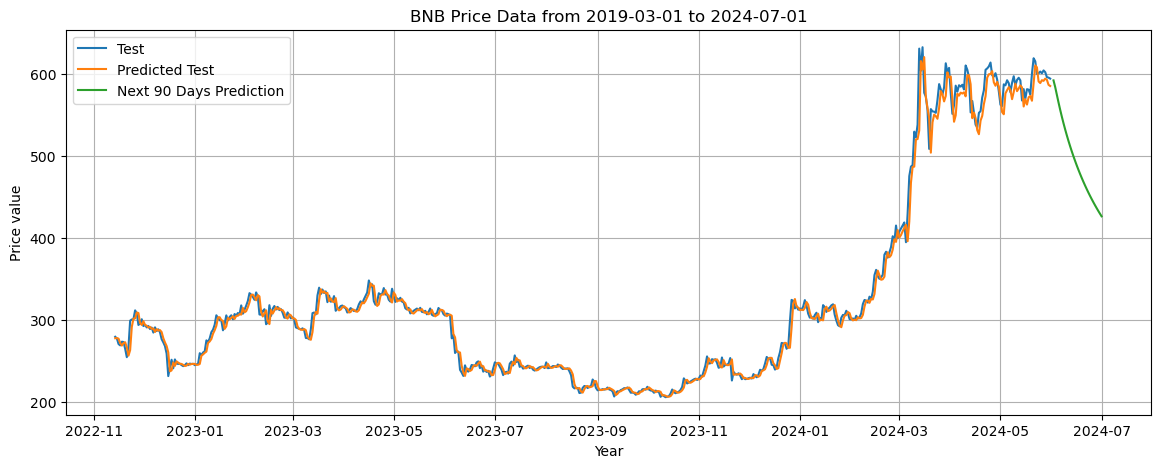

In [2]:
# The process of creating index to predict the next 90 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 90 days
lst_output = []
n_steps = time_step
i = 0
while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_30_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 90 days
print('Predicted XRP prices for the next 30 days:')
print(y_next_30_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 90 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_30_days, y_next_30_days, label='Next 90 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"BNB Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

<h2> Predicted Price for next 60 days


Predicted BNB prices for the next 60 days:
[591.60529565 583.62973721 574.24507781 564.90210236 555.99239355
 547.5633629  539.58963411 532.02948343 524.84361339 517.99833475
 511.46652111 505.22422807 499.25085229 493.52801781 488.03886014
 482.76798644 477.70179374 472.82747455 468.13341464 463.60903393
 459.24450804 455.03096719 450.95997915 447.02402646 443.21579058
 439.52882799 435.95701338 432.49461917 429.13635532 425.87732954
 422.71288818 419.638656   416.65061577 413.74502864 410.9183149
 408.1670539  405.48810345 402.8785202  400.33551993 397.85639795
 395.43864844 393.07988493 390.77795957 388.53068476 386.33611152
 384.19229089 382.09739324 380.04970825 378.04748583 376.08933385
 374.17370111 372.29915572 370.46442488 368.66811646 366.90903724
 365.18599397 363.49799227 361.84371958 360.22230086 358.63266218]


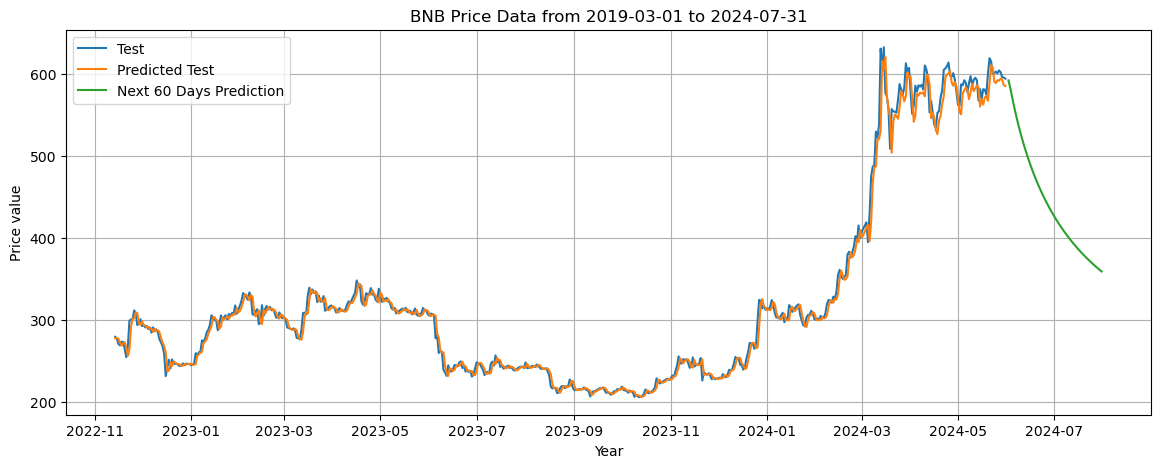

In [3]:
# The process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 60):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_60_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 60 days
print('Predicted BNB prices for the next 60 days:')
print(y_next_60_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_60_days = pd.date_range(start=next_date, periods=60).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_60_days, y_next_60_days, label='Next 60 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"BNB Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_60_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

<h2> Predict Price for the next 90 days </h2>

Predicted BNB prices for the next 90 days:
[591.60529565 583.62973721 574.24507781 564.90210236 555.99239355
 547.5633629  539.58963411 532.02948343 524.84361339 517.99833475
 511.46652111 505.22422807 499.25085229 493.52801781 488.03886014
 482.76798644 477.70179374 472.82747455 468.13341464 463.60903393
 459.24450804 455.03096719 450.95997915 447.02402646 443.21579058
 439.52882799 435.95701338 432.49461917 429.13635532 425.87732954
 422.71288818 419.638656   416.65061577 413.74502864 410.9183149
 408.1670539  405.48810345 402.8785202  400.33551993 397.85639795
 395.43864844 393.07988493 390.77795957 388.53068476 386.33611152
 384.19229089 382.09739324 380.04970825 378.04748583 376.08933385
 374.17370111 372.29915572 370.46442488 368.66811646 366.90903724
 365.18599397 363.49799227 361.84371958 360.22230086 358.63266218
 357.07388873 355.54510546 354.04543732 352.57400928 351.12998605
 349.71269148 348.32136983 346.95534494 345.61378154 344.29616255
 343.00177203 341.73001336 340.480

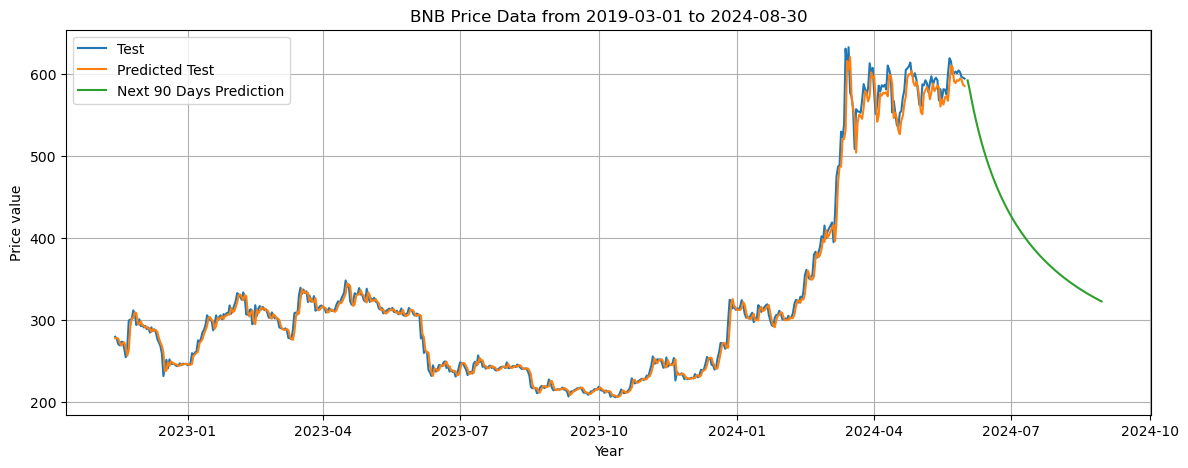

In [4]:
# The process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 90):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_90_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 60 days
print('Predicted BNB prices for the next 90 days:')
print(y_next_90_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_90_days, y_next_90_days, label='Next 90 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"BNB Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_90_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()